In [1]:
import tenseal as ts
import numpy as np
import math

import matplotlib.pyplot as plt

In [3]:
## Is this (N=2**16) actually possible? ANSWER: NO!

# SEAL Context
bits_scale = 26
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=2**15,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

In [2]:
# SEAL Context
bits_scale = 26
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

### error depending on vector size
### result: independent of vector size

In [4]:
rounds = 100

for i in range(int(math.log2(4096))):
    N = pow(2,i)
    ones = np.ones(N)

    cum_mean = 0
    for _ in range(rounds):
        ones_enc = ts.ckks_vector(context, ones)
        ones_dec = ones_enc.decrypt()
        cum_mean += np.abs(ones_dec - ones).mean()

    print(f"len(v) = {N}, mean err: {cum_mean/rounds}")

len(v) = 1, mean err: 1.401839337590749e-05
len(v) = 2, mean err: 1.8117602033781432e-05
len(v) = 4, mean err: 1.796873172375757e-05
len(v) = 8, mean err: 1.9529774435574075e-05
len(v) = 16, mean err: 1.7830580636980716e-05
len(v) = 32, mean err: 1.5063375666852855e-05
len(v) = 64, mean err: 1.4224077303905315e-05
len(v) = 128, mean err: 1.406488217622146e-05
len(v) = 256, mean err: 1.3803541111702317e-05
len(v) = 512, mean err: 1.395434384044843e-05
len(v) = 1024, mean err: 1.4384225107751145e-05
len(v) = 2048, mean err: 1.4427745751631686e-05


### error depending on Q
### result: independent

In [5]:
bits_scale = 26
ones = np.ones(1000)
zeros = np.zeros(1000)

for factors in range(7):
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[31] + [bits_scale]*factors + [31]
    )
    context.global_scale = 2**bits_scale
    context.generate_galois_keys()

    cum_mean = 0
    cum_err = 0
    for _ in range(rounds):
        ones_enc = ts.ckks_vector(context, ones)
        ones_dec = ones_enc.decrypt()
        cum_mean += np.abs(ones_dec - ones).mean()

        zeros_enc = ts.ckks_vector(context, zeros)
        cum_err += np.abs(zeros_enc.decrypt()).mean()

    print(f"factors = {factors} ({2*31+factors*bits_scale}), mean err: {cum_mean/rounds}, {cum_err/rounds}")

factors = 0 (62), mean err: 1.3988443618649848e-05, 1.399497324375353e-05
factors = 1 (88), mean err: 1.4833185024626164e-05, 1.4785487296593628e-05
factors = 2 (114), mean err: 1.4155788399069742e-05, 1.4218122521155629e-05
factors = 3 (140), mean err: 1.45677832579201e-05, 1.456165042455411e-05
factors = 4 (166), mean err: 1.4691304533474303e-05, 1.4744860671502463e-05
factors = 5 (192), mean err: 1.4624539694092897e-05, 1.4689544841450806e-05
factors = 6 (218), mean err: 1.4757377194581788e-05, 1.4692555224992763e-05


### error depending on N
### result: larger N - larger noise

In [6]:
rounds = 100
ones = np.ones(1000)
zeros = np.zeros(1000)

for power in range(12,16):
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=2**power,
        coeff_mod_bit_sizes=[40,28,40]
    )
    context.global_scale = pow(2,35)
    context.generate_galois_keys()

    ones = np.ones(2**(power-1))

    cum_mean = [0,0]
    for _ in range(rounds):
        ones_enc = ts.ckks_vector(context, ones)
        ones_dec = ones_enc.decrypt()
        cum_mean[0] += np.abs(ones_dec - ones).mean()

        zeros_enc = ts.ckks_vector(context, zeros)
        cum_mean[1] += np.abs(zeros_enc.decrypt()).mean()

    print(f"N = {2**power}, mean err: {cum_mean[0]/rounds}, {cum_mean[1]/rounds}")

N = 4096, mean err: 1.3940951868617502e-08, 1.4016632973412724e-08
N = 8192, mean err: 2.809439576312192e-08, 2.8212033837876242e-08
N = 16384, mean err: 5.6057142270892667e-08, 5.6507270622196076e-08
N = 32768, mean err: 1.126867003570538e-07, 1.1385114112334778e-07


### error depending on scale
### result: larger scale - smaller error

In [85]:
rounds = 100
ones = np.ones(1000)

for bits_scale in range(20,41):
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=4096,
        coeff_mod_bit_sizes=[bits_scale+2,bits_scale+2]
    )
    context.global_scale = pow(2,bits_scale)
    context.generate_galois_keys()

    cum_mean = [0,0]
    for _ in range(rounds):
        ones_enc = ts.ckks_vector(context, ones)
        ones_dec = ones_enc.decrypt()
        cum_mean[0] += np.abs(ones_dec - ones).mean()

        zeros_enc = ts.ckks_vector(context, zeros)
        cum_mean[1] += np.abs(zeros_enc.decrypt()).mean()

    print(f"scale = {bits_scale}, mean err: {cum_mean[0]/rounds}, {cum_mean[1]/rounds}")

scale = 20, mean err: 0.0004600849456141923, 0.000459079393921872
scale = 21, mean err: 0.00022897189663774497, 0.00022842234780902872
scale = 22, mean err: 0.00011574096328215578, 0.00011547308648206555
scale = 23, mean err: 5.779782011234685e-05, 5.764629531064816e-05
scale = 24, mean err: 2.8757916740253435e-05, 2.8834825276405593e-05
scale = 25, mean err: 1.4677669651701036e-05, 1.4597299592229113e-05
scale = 26, mean err: 7.3105883794934876e-06, 7.278629977414044e-06
scale = 27, mean err: 3.646272661822824e-06, 3.661231885859972e-06
scale = 28, mean err: 1.815913714239526e-06, 1.8129870872689068e-06
scale = 29, mean err: 9.244405772471532e-07, 9.23740753678079e-07
scale = 30, mean err: 4.500813111556456e-07, 4.520433771529676e-07
scale = 31, mean err: 2.2669142147112242e-07, 2.2479866642825063e-07
scale = 32, mean err: 1.1181236042956403e-07, 1.1129498520205299e-07
scale = 33, mean err: 5.5812952763503186e-08, 5.588936806591887e-08
scale = 34, mean err: 2.82593436164269e-08, 2.827

### Contour plot: error vs. scale and N

In [9]:
# plot errors vs. N and scale
rounds = 100

n = list(range(12,16))
bit_scales = list(range(20,51))
e = []

for n_i in n:
    N = 2**n_i
    zeros = np.zeros(int(N/2))
    print(f"N = {N}")

    errors = []

    for bits_scale in bit_scales:
        context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=N,
            coeff_mod_bit_sizes=[54,54]
        )
        context.global_scale = pow(2,bits_scale)
        context.generate_galois_keys()

        cum_mean = 0
        for _ in range(rounds):
            zeros_enc = ts.ckks_vector(context, zeros)
            cum_mean += np.abs(zeros_enc.decrypt()).mean()

        # print(f"scale = {bits_scale}, mean err: {cum_mean/rounds}")
        errors.append(cum_mean/rounds)

    e.append(errors)



N = 4096
N = 8192
N = 16384
N = 32768


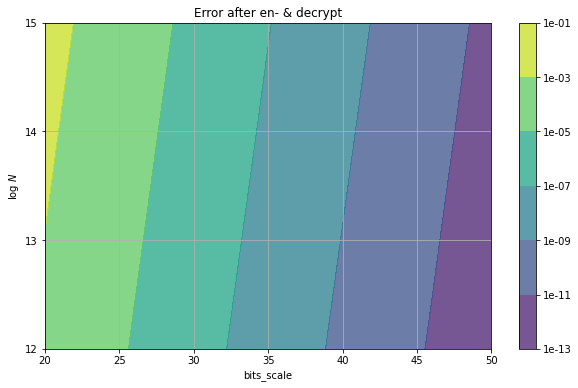

In [10]:
from matplotlib import ticker, cm

fig, ax = plt.subplots(figsize=(10,6))

cf = ax.contourf(bit_scales,n,e,alpha=0.75,locator=ticker.LogLocator())
fig.colorbar(cf, ax=ax, format=ticker.LogFormatter(10))

# plt.contourf(bit_scales, n, e)
plt.yticks(n)
plt.ylabel(f"log $N$")
plt.xlabel(f"bits_scale")
plt.title("Error after en- & decrypt")
plt.grid()
plt.show()

### trying to get towards the edge: minimal error (until error occurs)

In [8]:
bit_scales = list(range(50,60))
zeros = np.zeros(8192//2)
rounds = 100
end = False

for bits_scale in bit_scales:
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=8192,
        coeff_mod_bit_sizes=[60,60]
    )
    context.global_scale = pow(2,bits_scale)
    context.generate_galois_keys()

    cum_mean = 0
    for _ in range(rounds):
        try:
            zeros_enc = ts.ckks_vector(context, zeros)
            cum_mean += np.abs(zeros_enc.decrypt()).mean()
        except:
            print(f"Scale {bits_scale} out of bounds.")
            end = True
            break

    if end:
        break

    print(f"scale = {bits_scale}, mean err: {cum_mean/rounds}")

scale = 50, mean err: 8.512281665917543e-13
scale = 51, mean err: 4.300745889682652e-13
scale = 52, mean err: 2.1313777692870533e-13
scale = 53, mean err: 1.0617163571407262e-13
scale = 54, mean err: 5.296931106301873e-14
scale = 55, mean err: 2.6614305437404857e-14
scale = 56, mean err: 1.3438825439369354e-14
scale = 57, mean err: 6.705771550573814e-15
scale = 58, mean err: 3.368330590774204e-15
Scale 59 out of bounds.


### set: N
### vary: scale, vector data (0, 10, 100)

### Result: 
absolute error is the same for certain scale

i.e. relative error gets smaller, however fewer fractional bits are available

and one has to be cautions not to mess up fractional bits

In [24]:
N = 4096
bitscales = list(range(20,40,2))
values = [0,10,100]

rounds = 100

for bits_scale in bitscales:
    print(f"scale = {bits_scale}")
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=N,
        coeff_mod_bit_sizes=[54,54]
    )
    context.global_scale = pow(2,bits_scale)
    context.generate_galois_keys()

    for v in values:
        cum_err = 0
        for _ in range(rounds):
            x = np.full(N//2, v)
            x_enc = ts.ckks_vector(context, x)
            x_dec = x_enc.decrypt()
            cum_err += np.abs(x_dec - x).mean()

        print(f"  v = {v}: mean err = {cum_err/rounds}")

scale = 20
  v = 0: mean err = 0.0004555077075310458
  v = 10: mean err = 0.000456995688518875
  v = 100: mean err = 0.0004566959169138506
scale = 22
  v = 0: mean err = 0.00011544892614858425
  v = 10: mean err = 0.00011502513284514163
  v = 100: mean err = 0.00011510939453478586
scale = 24
  v = 0: mean err = 2.8517556504396146e-05
  v = 10: mean err = 2.8467176497412057e-05
  v = 100: mean err = 2.846875299397908e-05
scale = 26
  v = 0: mean err = 7.2137631268154316e-06
  v = 10: mean err = 7.237244819431731e-06
  v = 100: mean err = 7.2069153353235274e-06
scale = 28
  v = 0: mean err = 1.7992676042564954e-06
  v = 10: mean err = 1.8053845143776308e-06
  v = 100: mean err = 1.8024579009201514e-06
scale = 30
  v = 0: mean err = 4.506699839964519e-07
  v = 10: mean err = 4.476580832607491e-07
  v = 100: mean err = 4.502739922881971e-07
scale = 32
  v = 0: mean err = 1.1301396475442994e-07
  v = 10: mean err = 1.1285940822400656e-07
  v = 100: mean err = 1.1315875506803796e-07
scale = 

In [19]:
np.full(3,2)

array([2, 2, 2])

## noise after iteratively adding a fresh ciphertext

In [2]:
N = 4096
max_additions = 1000

values = [0,10,100]

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=N,
    coeff_mod_bit_sizes=[54,54]
)
context.global_scale = pow(2,40)
context.generate_galois_keys()

enc_dict = {v: ts.ckks_vector(context, np.full(N//2, v)) for v in values}

initial_errors = {k: np.abs(v.decrypt() - np.full(N//2,k)).mean() for k,v in enc_dict.items()}

enc_zeros = ts.ckks_vector(context, np.zeros(N//2))

errors = {v: np.empty(max_additions) for v in values}

for i in range(max_additions):
    for k,v in enc_dict.items():
        enc_dict[k] = v + enc_zeros
        errors[k][i] = np.abs(enc_dict[k].decrypt() - np.full(N//2,k)).mean()


value: initial error, final error, error per addition
  0: 4.3819079006511816e-10, 4.2219693253472597e-07, 4.2175874174466083e-10
 10: 4.584968012893986e-10, 4.222073891058109e-07, 4.217488923045215e-10
100: 4.4329953596822236e-10, 4.2221672817699396e-07, 4.2177342864102576e-10


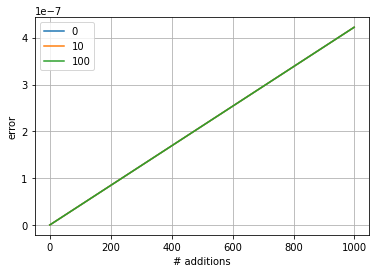

In [3]:
print("value: initial error, final error, error per addition")
for v in values:
    print(f"{v:3d}: {initial_errors[v]}, {errors[v][-1]}, {(errors[v][-1] - initial_errors[v]) / max_additions}")

Y = []
for k,v in errors.items():
    Y.append(v)
    plt.plot(v,label=k)

plt.legend()
plt.grid(True)
plt.xlabel("# additions")
plt.ylabel("error")
plt.show()

### Result:

Adding a fresh ciphertext linearly increases noise (as expected)

### noise after cascaded addition



In [150]:
N = 4096
max_additions = 14

values = np.array([0,1,2,4])

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=N,
    coeff_mod_bit_sizes=[54,54]
)
context.global_scale = pow(2,30)
context.generate_galois_keys()

enc_dict = {v: ts.ckks_vector(context, np.full(N//2, v)) for v in values}

initial_errors = {k: np.abs(v.decrypt() - np.full(N//2,k)).mean() for k,v in enc_dict.items()}

errors = {v: np.empty(max_additions) for v in values}

for i in range(max_additions):
    
    for k,v in enc_dict.items():
        enc_dict[k] = v + v
        errors[k][i] = np.abs(enc_dict[k].decrypt() - np.full(N//2, (2*k)*2**i)).mean()

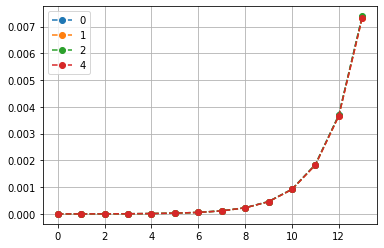

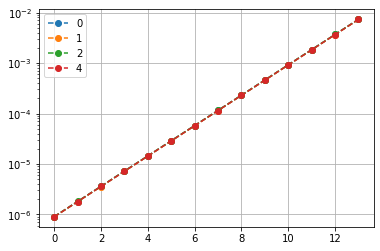

In [152]:
# print("value: initial error, final error, error per addition")
# for v in values:
#    print(f"{v:3d}: {initial_errors[v]}, {errors[v][-1]}, {(errors[v][-1] - initial_errors[v]) / max_additions}")

Y = []
for k,v in errors.items():
    Y.append(v)
    plt.plot(v,"o--",label=k)

plt.legend()
plt.grid()
plt.show()

for k,v in errors.items():
    Y.append(v)
    plt.plot(v,"o--",label=k)

plt.yscale("log")
plt.legend()
plt.grid()
plt.show()



### Result:

noise doubles (as expected), resulting in an exponential growth

### Noise after iterative multiplication of fresh ciphertext / plaintext

In [57]:
# SEAL Context
N = 8192
bits_scale = 26
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=N,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

In [58]:
ones = np.ones(N//2)
ones_enc = ts.ckks_vector(context, ones)
copy_enc = ones_enc.copy()
fresh_ct = ts.ckks_vector(context, ones)

max_mults = 6

ct_errors = []
ct_errors.append(np.abs(ones_enc.decrypt() - np.full(N//2,1)).mean())
pt_errors = ct_errors.copy()

for _ in range(max_mults):
    ones_enc *= ones_enc
    ct_errors.append(np.abs(ones_enc.decrypt() - np.full(N//2,1)).mean())

    copy_enc *= ones
    pt_errors.append(np.abs(copy_enc.decrypt() - np.full(N//2,1)).mean())

for i in range(len(ct_errors)):
    print(i, ct_errors[i], pt_errors[i])

0 1.4476120074047739e-05 1.4476120074047739e-05
1 0.0009791702032089233 0.000978127121925354
2 0.0036745071411132812 0.00269162654876709
3 0.009581223130226135 0.004899471998214722
4 0.023753002285957336 0.009335055947303772
5 0.05684317648410797 0.01778380572795868
6 0.1284887194633484 0.028327733278274536


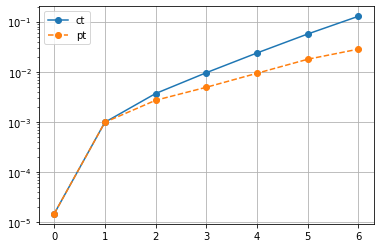

In [59]:
plt.plot(ct_errors, "o-", label="ct")
plt.plot(pt_errors, "o--", label="pt")
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

In [64]:
### other precision tests with multiplication

# special context
N = 16384
bits_scale = 30

max_mults = 12

bit_sizes = [39] + [bits_scale]*max_mults + [39]
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=N,
    coeff_mod_bit_sizes=bit_sizes
)

context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

In [65]:
ones = np.ones(N//2)
ones_enc = ts.ckks_vector(context, ones)
copy_enc = ones_enc.copy()

ct_errors = []
ct_errors.append(np.abs(ones_enc.decrypt() - np.full(N//2,1)).mean())
pt_errors = ct_errors.copy()
for _ in range(max_mults):
    ones_enc ** 2
    ct_errors.append(np.abs(ones_enc.decrypt() - np.full(N//2,1)).mean())

    copy_enc *= ones
    pt_errors.append(np.abs(copy_enc.decrypt() - np.full(N//2,1)).mean())

for i in range(len(ct_errors)):
    print(i, ct_errors[i], pt_errors[i])

0 1.804709946321998e-06 1.804709946321998e-06
1 9.160768240690231e-05 9.157601743936539e-05
2 0.0004274221137166023 0.0003358079120516777
3 0.0013745278120040894 0.0008551068603992462
4 0.0033939359709620476 0.0014969157055020332
5 0.007629655301570892 0.0023227622732520103
6 0.016496295109391212 0.0034864237532019615
7 0.03541338071227074 0.005573178641498089
8 0.07440888602286577 0.007756723091006279
9 0.15721500758081675 0.01025397703051567
10 0.3429169626906514 0.013098365627229214
11 0.8090017251670361 0.016230669803917408
12 2.2863269224762917 0.02052854187786579


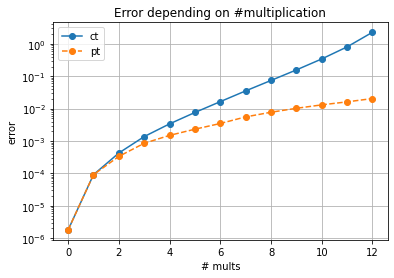

In [66]:
plt.plot(ct_errors, "o-", label="ct")
plt.plot(pt_errors, "o--", label="pt")
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.title("Error depending on #multiplication")
plt.ylabel("error")
plt.xlabel("# mults")
plt.show()

### Results:

Multiplying a ciphertext with a fresh ciphertext or plaintext data makes no difference!

But when multiplying ciphertext where both already used some levels of multiplication, error diverges

In [71]:
ones = np.ones(N//2)

N = 16384

max_mults = 10

min_scale = 25
max_scale = (439 - 2*39) // max_mults

errors = {scale: [] for scale in range(min_scale, max_scale + 1)}

for bits_scale in errors.keys():
    print(f"bits scale: {bits_scale}")
    bit_sizes = [39] + [bits_scale]*max_mults + [39]

    ## generate context
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=N,
        coeff_mod_bit_sizes=bit_sizes
    )

    context.global_scale = pow(2, bits_scale)
    # context.generate_galois_keys()

    ## encrypt
    ones_enc = ts.ckks_vector(context, ones)
    # copy_enc = ones_enc.copy()

    ## perform multiplications
    ct_errors = []
    print("Mults: ", end="")
    for i in range(max_mults):
        print(i, end=" ")
        ones_enc = ones_enc ** 2
        ct_errors.append(np.abs(ones_enc.decrypt() - np.full(N//2,1)).mean())

    errors[bits_scale] = ct_errors

    print("")
        

bits scale: 25
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 26
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 27
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 28
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 29
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 30
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 31
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 32
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 33
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 34
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 35
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 36
Mults: 0 1 2 3 4 5 6 7 8 9 


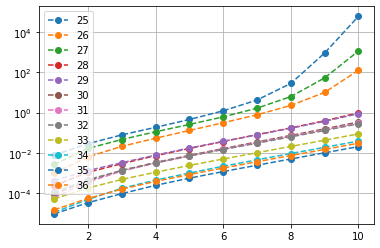

In [82]:
for k,v in errors.items():
    plt.plot(list(range(1,max_mults+1)), v, "o--", label=k)

plt.legend()
plt.grid()
plt.yscale("log")

plt.show()


# Plot:
# fix: N, # mult-levels
# vary: intermediate bit-sizes, scale

In [60]:
# same as above but for ct-pt multiplication
# because NNs only have ct-pt mults

ones = np.ones(N//2)

N = 16384

max_mults = 10

min_scale = 25
max_scale = (439 - 2*39) // max_mults

errors = {scale: [] for scale in range(min_scale, max_scale + 1)}

for bits_scale in errors.keys():
    print(f"bits scale: {bits_scale}")
    bit_sizes = [39] + [bits_scale]*max_mults + [39]

    ## generate context
    context = ts.context(
        ts.SCHEME_TYPE.CKKS,
        poly_modulus_degree=N,
        coeff_mod_bit_sizes=bit_sizes
    )

    context.global_scale = pow(2, bits_scale)
    # context.generate_galois_keys()

    ## encrypt
    ones_enc = ts.ckks_vector(context, ones)
    # copy_enc = ones_enc.copy()

    ## perform multiplications
    ct_errors = []
    print("Mults: ", end="")
    for i in range(max_mults):
        print(i, end=" ")
        ones_enc *= ones
        ct_errors.append(np.abs(ones_enc.decrypt() - np.full(N//2,1)).mean())

    errors[bits_scale] = ct_errors

    print("")

bits scale: 25
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 26
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 27
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 28
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 29
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 30
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 31
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 32
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 33
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 34
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 35
Mults: 0 1 2 3 4 5 6 7 8 9 
bits scale: 36
Mults: 0 1 2 3 4 5 6 7 8 9 


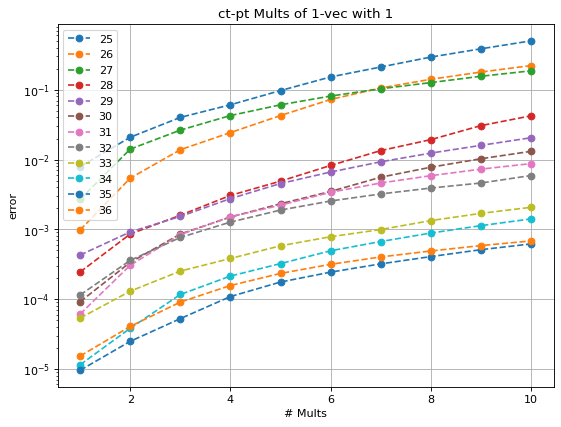

In [68]:
plt.figure(figsize=(8,6), dpi=80)

for k,v in errors.items():
    plt.plot(list(range(1,max_mults+1)), v, "o--", label=k)

plt.legend()
plt.grid()
plt.yscale("log")

plt.title("ct-pt Mults of 1-vec with 1")
plt.ylabel("error")
plt.xlabel("# Mults")
plt.show()

In [4]:
# x-axis: #mults
# y-axis: delta between ct-ct mult error and ct-pt mult error
# for different scales


# TODO!

In [ ]:
# 

In [33]:
# encrypt 0 with scale 30
# decrypt
# result should be values within 2sigma (2*3.19=6.38), 3sigma (3*3.19=9.57) * 2^(-30)

sigma = 3.19
sigma_sq = sigma**2
x = 2**(-30)

In [37]:
print(f"2^-30 = {x}")
print(f"2sigma*2^-30: {2*sigma*x}")
print(f"3sigma*2^-30: {3*sigma*x}")
print(f"6sigma*2^-30: {6*sigma*x}")

print()

print(f"2*sigma_sq * 2^-30 = {2*sigma_sq*x}")
print(f"3*sigma_sq * 2^-30 = {3*sigma_sq*x}")
print(f"6*sigma_sq * 2^-30 = {6*sigma_sq*x}")

2^-30 = 9.313225746154785e-10
2sigma*2^-30: 5.941838026046753e-09
3sigma*2^-30: 8.91275703907013e-09
6sigma*2^-30: 1.782551407814026e-08

2*sigma_sq * 2^-30 = 1.8954463303089142e-08
3*sigma_sq * 2^-30 = 2.8431694954633714e-08
6*sigma_sq * 2^-30 = 5.686338990926743e-08


abs mean: 8.888467377992267e-07
6.161973656219929e-07


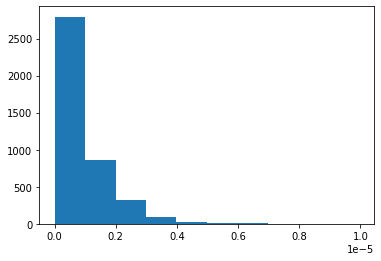

In [49]:
N = 2**13

zeros = np.zeros(N//2)

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=N,
    coeff_mod_bit_sizes=[60,60]
)
context.global_scale = pow(2,30)
context.generate_galois_keys()

zeros_enc = ts.ckks_vector(context, zeros)

result = zeros_enc.decrypt()

print(f"abs mean: {np.abs(result).mean()}")
mean30 = np.abs(result).mean()
result = np.abs(result)
result.sort()
print(result[len(result)//2])

plt.hist(result)
plt.show()

abs mean: 8.67107365732681e-10


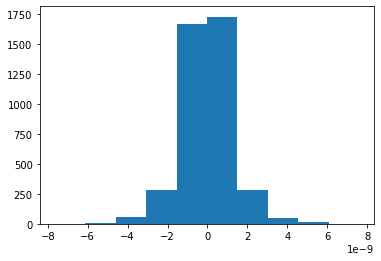

In [36]:
N = 2**13

zeros = np.zeros(N//2)

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=N,
    coeff_mod_bit_sizes=[60,60]
)
context.global_scale = pow(2,40)
context.generate_galois_keys()

zeros_enc = ts.ckks_vector(context, zeros)

result = zeros_enc.decrypt()

print(f"abs mean: {np.abs(result).mean()}")
mean40 = np.abs(result).mean()

plt.hist(result)
plt.show()

In [25]:
mean30 / mean40

1103.4824802807595

In [26]:
mean40 / mean30

0.0009062219091557933

In [27]:
2**(30-40)

0.0009765625

In [2]:
2**27

134217728

In [69]:
## plain multiplication: multiplying with 1s vs 2s
N = 16384
bits_scale = 29

max_mults = 12

bit_sizes = [45] + [bits_scale]*max_mults + [45]
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=N,
    coeff_mod_bit_sizes=bit_sizes
)

context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()


ones = np.ones(N//2)
twos = np.full(N//2, 2)

ones_enc_x1 = ts.ckks_vector(context, ones)
ones_enc_x2 = ones_enc_x1.copy()

err_x1 = []
err_x2 = []
for i in range(max_mults):
    ones_enc_x1 *= ones
    ones_enc_x2 *= twos

    print(i, ones_enc_x1.decrypt()[0], ones_enc_x2.decrypt()[0])

    err_x1.append(np.abs(ones_enc_x1.decrypt() - ones).mean())
    err_x2.append(np.abs(ones_enc_x2.decrypt() - np.full(N//2, 2**(i+1))).mean())

for i in range(max_mults):
    print(err_x1[i], err_x2[i])

0 1.000427157058203 2.000855020093171
1 1.0009148760866504 4.003666425399156
2 1.0015253871482717 8.012223790238894
3 1.0027492094715436 16.04403214273312
4 1.0045273399668355 32.14496100288071
5 1.0066163781252624 64.42361363371408
6 1.0092648676506062 129.1862794286909
7 1.012353322461839 259.1634634448208
8 1.0159511145670004 520.168341468185
9 1.0204992277038663 1044.992718336432
10 1.0258233687734708 2100.88479956074
11 1.0317411656536255 4226.015529084594
0.0004273671656847 0.0008549131453037262
0.0009161718189716339 0.003664795309305191
0.0015274174511432648 0.012219889089465141
0.002751443535089493 0.044024743139743805
0.004529451951384544 0.14494668692350388
0.006618371233344078 0.4235848467797041
0.009267264977097511 1.1862201448529959
0.01235671155154705 3.1633435245603323
0.015953142195940018 8.16810135729611
0.020500104874372482 20.992233054712415
0.0258219912648201 52.883822944015265
0.03174139931797981 130.013565370813


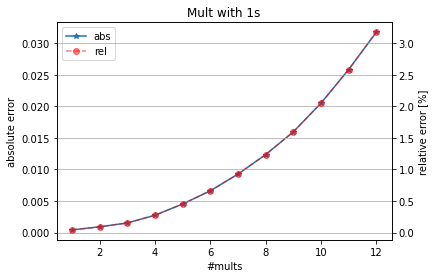

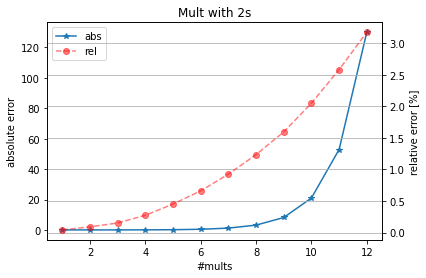

In [70]:
rel_err_x1 = [e * 100 for e in err_x1]
rel_err_x2 = [e * 100 / (2**(i+1)) for i,e in enumerate(err_x2)]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
l1 = ax1.plot(list(range(1,max_mults+1)), err_x1, "*-", label="abs")
l2 = ax2.plot(list(range(1,max_mults+1)), rel_err_x1, "o--", label="rel", color="red", alpha=0.5)

lns = l1 + l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlabel("#mults")
ax1.set_ylabel('absolute error')
ax2.set_ylabel("relative error [%]")
plt.title("Mult with 1s")
plt.grid()
plt.show()


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
l1 = ax1.plot(list(range(1,max_mults+1)), err_x2, "*-", label="abs")
l2 = ax2.plot(list(range(1,max_mults+1)), rel_err_x2, "o--", label="rel", color="red", alpha=0.5)

lns = l1 + l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlabel("#mults")
ax1.set_ylabel('absolute error')
ax2.set_ylabel("relative error [%]")

plt.title("Mult with 2s")
plt.grid()
plt.show()



In [98]:
# same as above, but instead of multiplying by a constant, multiply by a random vector of "weights" in [-1,1]

N = 16384
bits_scale = 36

max_mults = 10

bit_sizes = [38] + [bits_scale]*max_mults + [38]
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=N,
    coeff_mod_bit_sizes=bit_sizes
)

context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

ones = np.ones(N//2)
factors = np.random.uniform(low=-1, high=1, size=max_mults)

# pre-compute individual products
products = np.cumprod(factors)

for f,p in zip(factors,products):
    print(f,p)

ones_enc = ts.ckks_vector(context, ones)

err = []
print("factor, cumm. product, decrypted, error")
for f,p in zip(factors,products):
    ones_enc *= f
    
    dec = ones_enc.decrypt()
    e = np.abs(dec - np.full(N//2, p)).mean()
    err.append(e)
    print(f"{f:+.8f}, {p:+.8f}, {np.mean(dec):+.8f}, {e}")


0.8598803957615178 0.8598803957615178
-0.4308664054902598 -0.3704935752733072
0.2583823862262349 -0.09572901406060629
0.5457841685898235 -0.052247380348991526
-0.8881002969624874 0.0464009140034514
0.03557194363777305 0.0016505706976719275
0.03031981027855668 5.0044990404757776e-05
-0.572433043226316 -2.864740615562728e-05
0.3916135188454415 -1.121871153039976e-05
0.9411699433487011 -1.0558714095511761e-05
factor, cumm. product, decrypted, error
0.85988040, 0.85988040, 0.85989352, 1.3120410205846866e-05
-0.43086641, -0.37049358, -0.37050859, 1.501752076005225e-05
0.25838239, -0.09572901, -0.09573769, 8.674182782844597e-06
0.54578417, -0.05224738, -0.05225555, 8.172073147336145e-06
-0.88810030, 0.04640091, 0.04641173, 1.082059477171965e-05
0.03557194, 0.00165057, 0.00165109, 5.193191494718644e-07
0.03031981, 0.00005004, 0.00005006, 3.372977121192036e-08
-0.57243304, -0.00002865, -0.00002866, 3.543520636469756e-08
0.39161352, -0.00001122, -0.00001123, 3.1165069396074896e-08
0.94116994, -

0.0015258412996178746
-0.004053382234489239
-0.00906118470765086
-0.01564111557890554
0.02331978799149256
0.031463005504965405
0.06739889635129927
-0.12369429250311702
-0.27779544301166625
-0.38797453436510526


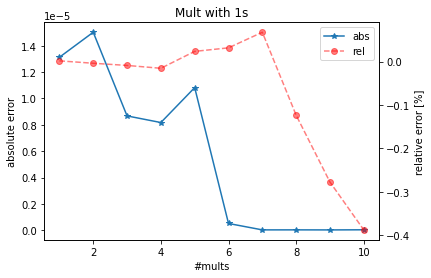

In [99]:
rel_err = [100*e / p for e,p in zip(err, products)]
for re in rel_err:
    print(re)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
l1 = ax1.plot(list(range(1,max_mults+1)), err, "*-", label="abs")
l2 = ax2.plot(list(range(1,max_mults+1)), rel_err, "o--", label="rel", color="red", alpha=0.5)

lns = l1 + l2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_xlabel("#mults")
ax1.set_ylabel('absolute error')
ax2.set_ylabel("relative error [%]")
plt.title("Mult with 1s")
plt.show()

In [11]:
## Multiplication Noise

## ct1 = m1 + ε1
## ct2 = m2 + ε2

## check if this is correct:
##
## ct1 * ct2 = m1*m2 + (noise), where noise = m1*ε2 + m2*ε1 + ε1*ε2

N = 2**13

ones = np.ones(N//2)
twos = np.full(N//2, 2.0)

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=N,
    coeff_mod_bit_sizes=[60,30,60]
)
context.global_scale = pow(2,30)
# context.generate_galois_keys()

ones_enc = ts.ckks_vector(context, ones)
twos_enc = ts.ckks_vector(context, twos)

v_eps1 = ones_enc.decrypt() - np.full(N//2, 1.0)
v_eps2 = twos_enc.decrypt() - np.full(N//2, 2.0)

print(v_eps1[:10])
print(v_eps2[:10])

result = (ones_enc * twos_enc).decrypt()

noise_real = result - np.full(N//2, 2.0)

noise_calc = v_eps2 * 1.0 + v_eps1 * 2.0 + v_eps1 * v_eps2

for i in range(10):
    print(f"{i:2d}: {noise_real[i]:.10f}, {noise_calc[i]:.10f}")

ones_dec = np.array(ones_enc.decrypt())
twos_dec = np.array(twos_enc.decrypt())
res_dec = ones_dec * twos_dec

for i in range(10):
    print(f"{result[i]:.10f} vs {res_dec[i]:.10f}")



[ 2.10164855e-07  2.84617016e-07  1.99852580e-06  2.47206249e-06
 -4.74702960e-07 -7.60137472e-07  2.59075237e-06  3.32726462e-06
 -2.16787321e-07  1.06102159e-06]
[-2.11024367e-06  9.49059923e-07 -1.70597523e-07 -2.02677123e-07
  3.00598829e-06 -4.68767382e-07  3.22416501e-07  1.65479121e-06
  1.97024091e-06  1.14987158e-06]
 0: 0.0000898499, -0.0000016899
 1: 0.0000925657, 0.0000015183
 2: 0.0000936440, 0.0000038265
 3: 0.0000953132, 0.0000047414
 4: 0.0000947270, 0.0000020566
 5: 0.0000901953, -0.0000019890
 6: 0.0000969141, 0.0000055039
 7: 0.0000995098, 0.0000083093
 8: 0.0000911544, 0.0000015367
 9: 0.0000937223, 0.0000032719
2.0000898499 vs 1.9999983101
2.0000925657 vs 2.0000015183
2.0000936440 vs 2.0000038265
2.0000953132 vs 2.0000047414
2.0000947270 vs 2.0000020566
2.0000901953 vs 1.9999980110
2.0000969141 vs 2.0000055039
2.0000995098 vs 2.0000083093
2.0000911544 vs 2.0000015367
2.0000937223 vs 2.0000032719


In [7]:
x = np.full(10,2)
y = np.full(10,3)

x*1.4

array([2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8])